In [1]:
import os
import gzip
import shutil
import pandas as pd


In [2]:
directory_train = 'SMNI_CMI_TRAIN'
directory_test = 'SMNI_CMI_TEST'

# Preprocessing
Unzipping file

In [3]:
def unzip(directory):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                rel_path = os.path.join(directory, foldername, filename)
                with gzip.open(rel_path, 'rb') as f_in:
                    des_dir = des_path = os.path.join(directory + '_EXTRACTED',foldername)
                    des_file = filename + '.txt'
                    if not os.path.exists(des_dir):
                        os.makedirs(des_dir)
                    des_path = os.path.join(des_dir, des_file)
                    with open(des_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)

In [3]:
from operator import index
def extract_text(directory):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            metadata = pd.DataFrame(index=[0], columns=['filename', 'trials', 'samples', 'post_stim_samples', 'stimulation', 'trial'])
            des_dir = os.path.join(directory.replace('EXTRACTED','CSV'),foldername)
            for filename in os.listdir(folder):
                rel_path = os.path.join(directory, foldername, filename)
                with open(rel_path) as file:
                    lines = []
                    for i in range(4):
                        line = next(file).strip()
                        lines = lines + line.split()
                    lines = [value for value in lines if value != '#']
                    meta_temp = pd.DataFrame(index=[0], columns=['filename', 'trials', 'samples', 'post_stim_samples', 'stimulation', 'trial'])
                    meta_temp['filename'] = lines[0]
                    meta_temp['trials'] = lines[1]
                    meta_temp['samples'] = lines[5]
                    meta_temp['post_stim_samples'] = lines[7]
                    if lines[14] == 'nomatch,':
                        meta_temp['stimulation'] = lines[13] + ' ' + lines[14].replace(",", "")
                        meta_temp['trial'] = lines[16]
                    else:
                        meta_temp['stimulation'] = lines[13] + ' ' + lines[14]
                        meta_temp['trial'] = lines[17]
                    metadata = pd.concat([metadata, meta_temp], ignore_index=True)
                    pd_data = pd.DataFrame()
                    for _ in range(64):
                        time_series = pd.DataFrame(index=[0])
                        channel = next(file).split()
                        time_series['Channel_Number'] = channel[3]
                        time_series['Channel'] = channel[1]
                        temp_data = next(file).split()
                        time_series['Trial'] = temp_data[0]
                        time_series[str(temp_data[2])] = temp_data[3]
                        for _ in range(255):
                            temp_data = next(file).split()
                            pd_temp = pd.DataFrame({str(temp_data[2]):[temp_data[3]]})
                            time_series = pd.concat((time_series, pd_temp), axis=1)
                        pd_data = pd.concat([pd_data, time_series], ignore_index=True)
                    des_file = foldername+'_'+ str(meta_temp['trial'][0]) + '.csv'
                    if not os.path.exists(des_dir):
                        os.makedirs(des_dir)
                    des_path = os.path.join(des_dir, des_file)
                    pd_data.to_csv(des_path, index=False)
            des_path = os.path.join(des_dir, foldername + '_Metadata.csv')
            metadata.to_csv(des_path)

In [4]:
extract_text('SMNI_CMI_TRAIN_EXTRACTED')

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Using matplotlib as 2D backend.


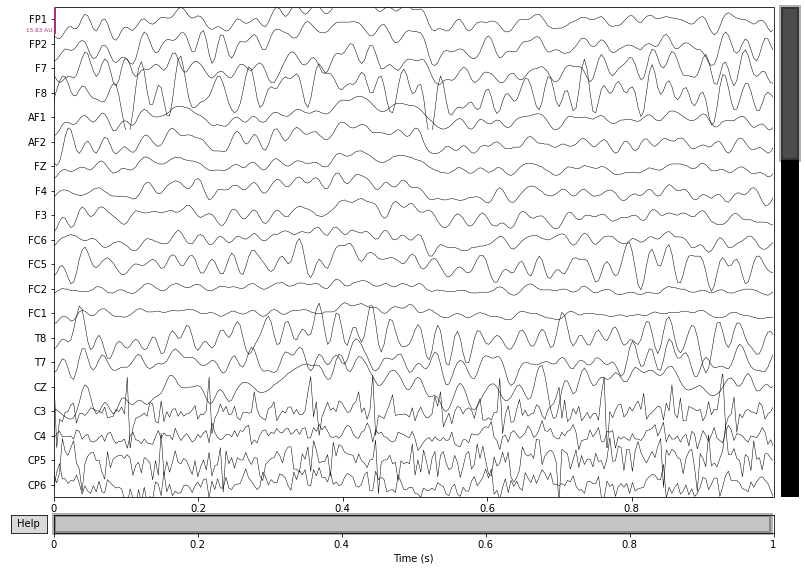

In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Qt5Agg')
plt.ion()

data_column = [x for x in range(0,256)]

# Read the CSV file as a NumPy array
data = np.loadtxt('out.csv', delimiter=',', skiprows=1, usecols=tuple([x+3 for x in data_column]))
raw_data = pd.read_csv('out.csv')

# Some information about the channels
ch_names = raw_data['Channel'].tolist()

# Sampling rate of the Nautilus machine
sfreq = 256  # Hz

# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq)

# Finally, create the Raw object
raw = mne.io.RawArray(data, info)

# Plot it!
raw.plot()

In [ ]:
events = mne.find_events(raw, stim_channel='FP1', min_duration = 1 / raw.info['sfreq'])
print(events[:5])  # show the first 5
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV